In [1]:
import os 
import pandas as pd
import re
import pickle
import numpy as np
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns
from sklearn.manifold import TSNE
# import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import random
import sklearn

#python으로 확인할 시, 한글폰트 필요
import seaborn as sns
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style='white')
np.random.seed(42)
random.seed(42)
import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('../')

from model import DecisionTree
from sklearn.preprocessing import OrdinalEncoder
import os

In [2]:
data_path = "../data/"

cols = ['no', 'id', 'ageD', 'CLU_A', 'CLU_B', 'CLU_C1', 'CLU_C3', 'CLU_C5', 'CLU_E2', 'CLU_E4',
       'CLU_E5', 'CLU_F2', 'CLU_F3', 'CLU_G4', 'CLU_G6', 'CLU_H21', 'CLU_H22',
       'CLU_H23', 'CLU_H24', 'CLU_J', 'CLU_LB', 'CLU_LC', 'CLU_LD', 'CLU_LI',
       'CLU_LF', 'CLU_LG', 'CLU_LI2', 'CLU_LK','CLUSTER1','CLUSTER2']
embed_model = 'srgnn'
filename = {'sage' : 'user_embedding_sage_sid_6to6_weighted.npy', 'srgnn' : 'srgnn_user_hybrid_6to6_weighted.npy'}

survey = pd.read_excel(os.path.join(data_path,'survey_string.xlsx'))
survey = survey.drop(cols,axis=1)

with open(os.path.join(data_path, 'MAC_to_idx_final.pkl'),'rb') as fin:
    mac_to_idx = pickle.load(fin)

# sage, srgnn 중 선택
pivot_df = pd.read_csv(os.path.join(data_path, 'pivot_genre2_data.csv'), index_col=0)
embedding = np.load(os.path.join(data_path, filename[embed_model]))

In [3]:
def name_prep(x):
    x=re.sub('\.','',x) #kt
    x=re.sub('-','',x) #skt
    x=re.sub(':','',x) #uplus
    x=x.lower()
    return x 

In [4]:
survey.loc[:,'Mac_Address'] = survey.loc[:,'Mac_Address'].map(name_prep)
survey.loc[:,'Mac_Address'] = survey.loc[:,'Mac_Address'].map(mac_to_idx)
survey_label = pd.read_excel(os.path.join(data_path,'survey_label.xlsx'))
survey_label = dict(zip(survey_label['no'],survey_label['데이터타입']))
onehot_cols = [k for k,v in survey_label.items() if v==0]
ordinal_cols = [k for k,v in survey_label.items() if v==1]
survey.drop('SQ4_1a',axis=1,inplace=True) #통신사 묻는 질문은 그냥 뺌 

encoder_ordinal = OrdinalEncoder()
onehot_cols = [col for col in onehot_cols if col in survey.columns]
ordinal_cols = [col for col in ordinal_cols if col in survey.columns]

encoded_survey = pd.get_dummies(survey, columns=onehot_cols, prefix=onehot_cols)
encoded = encoder_ordinal.fit_transform(encoded_survey[ordinal_cols]) #ordinal encoding
encoded_survey[ordinal_cols] = encoded

encoded_survey.dropna(axis=1,inplace=True)
encoded_survey.set_index('Mac_Address', inplace=True)

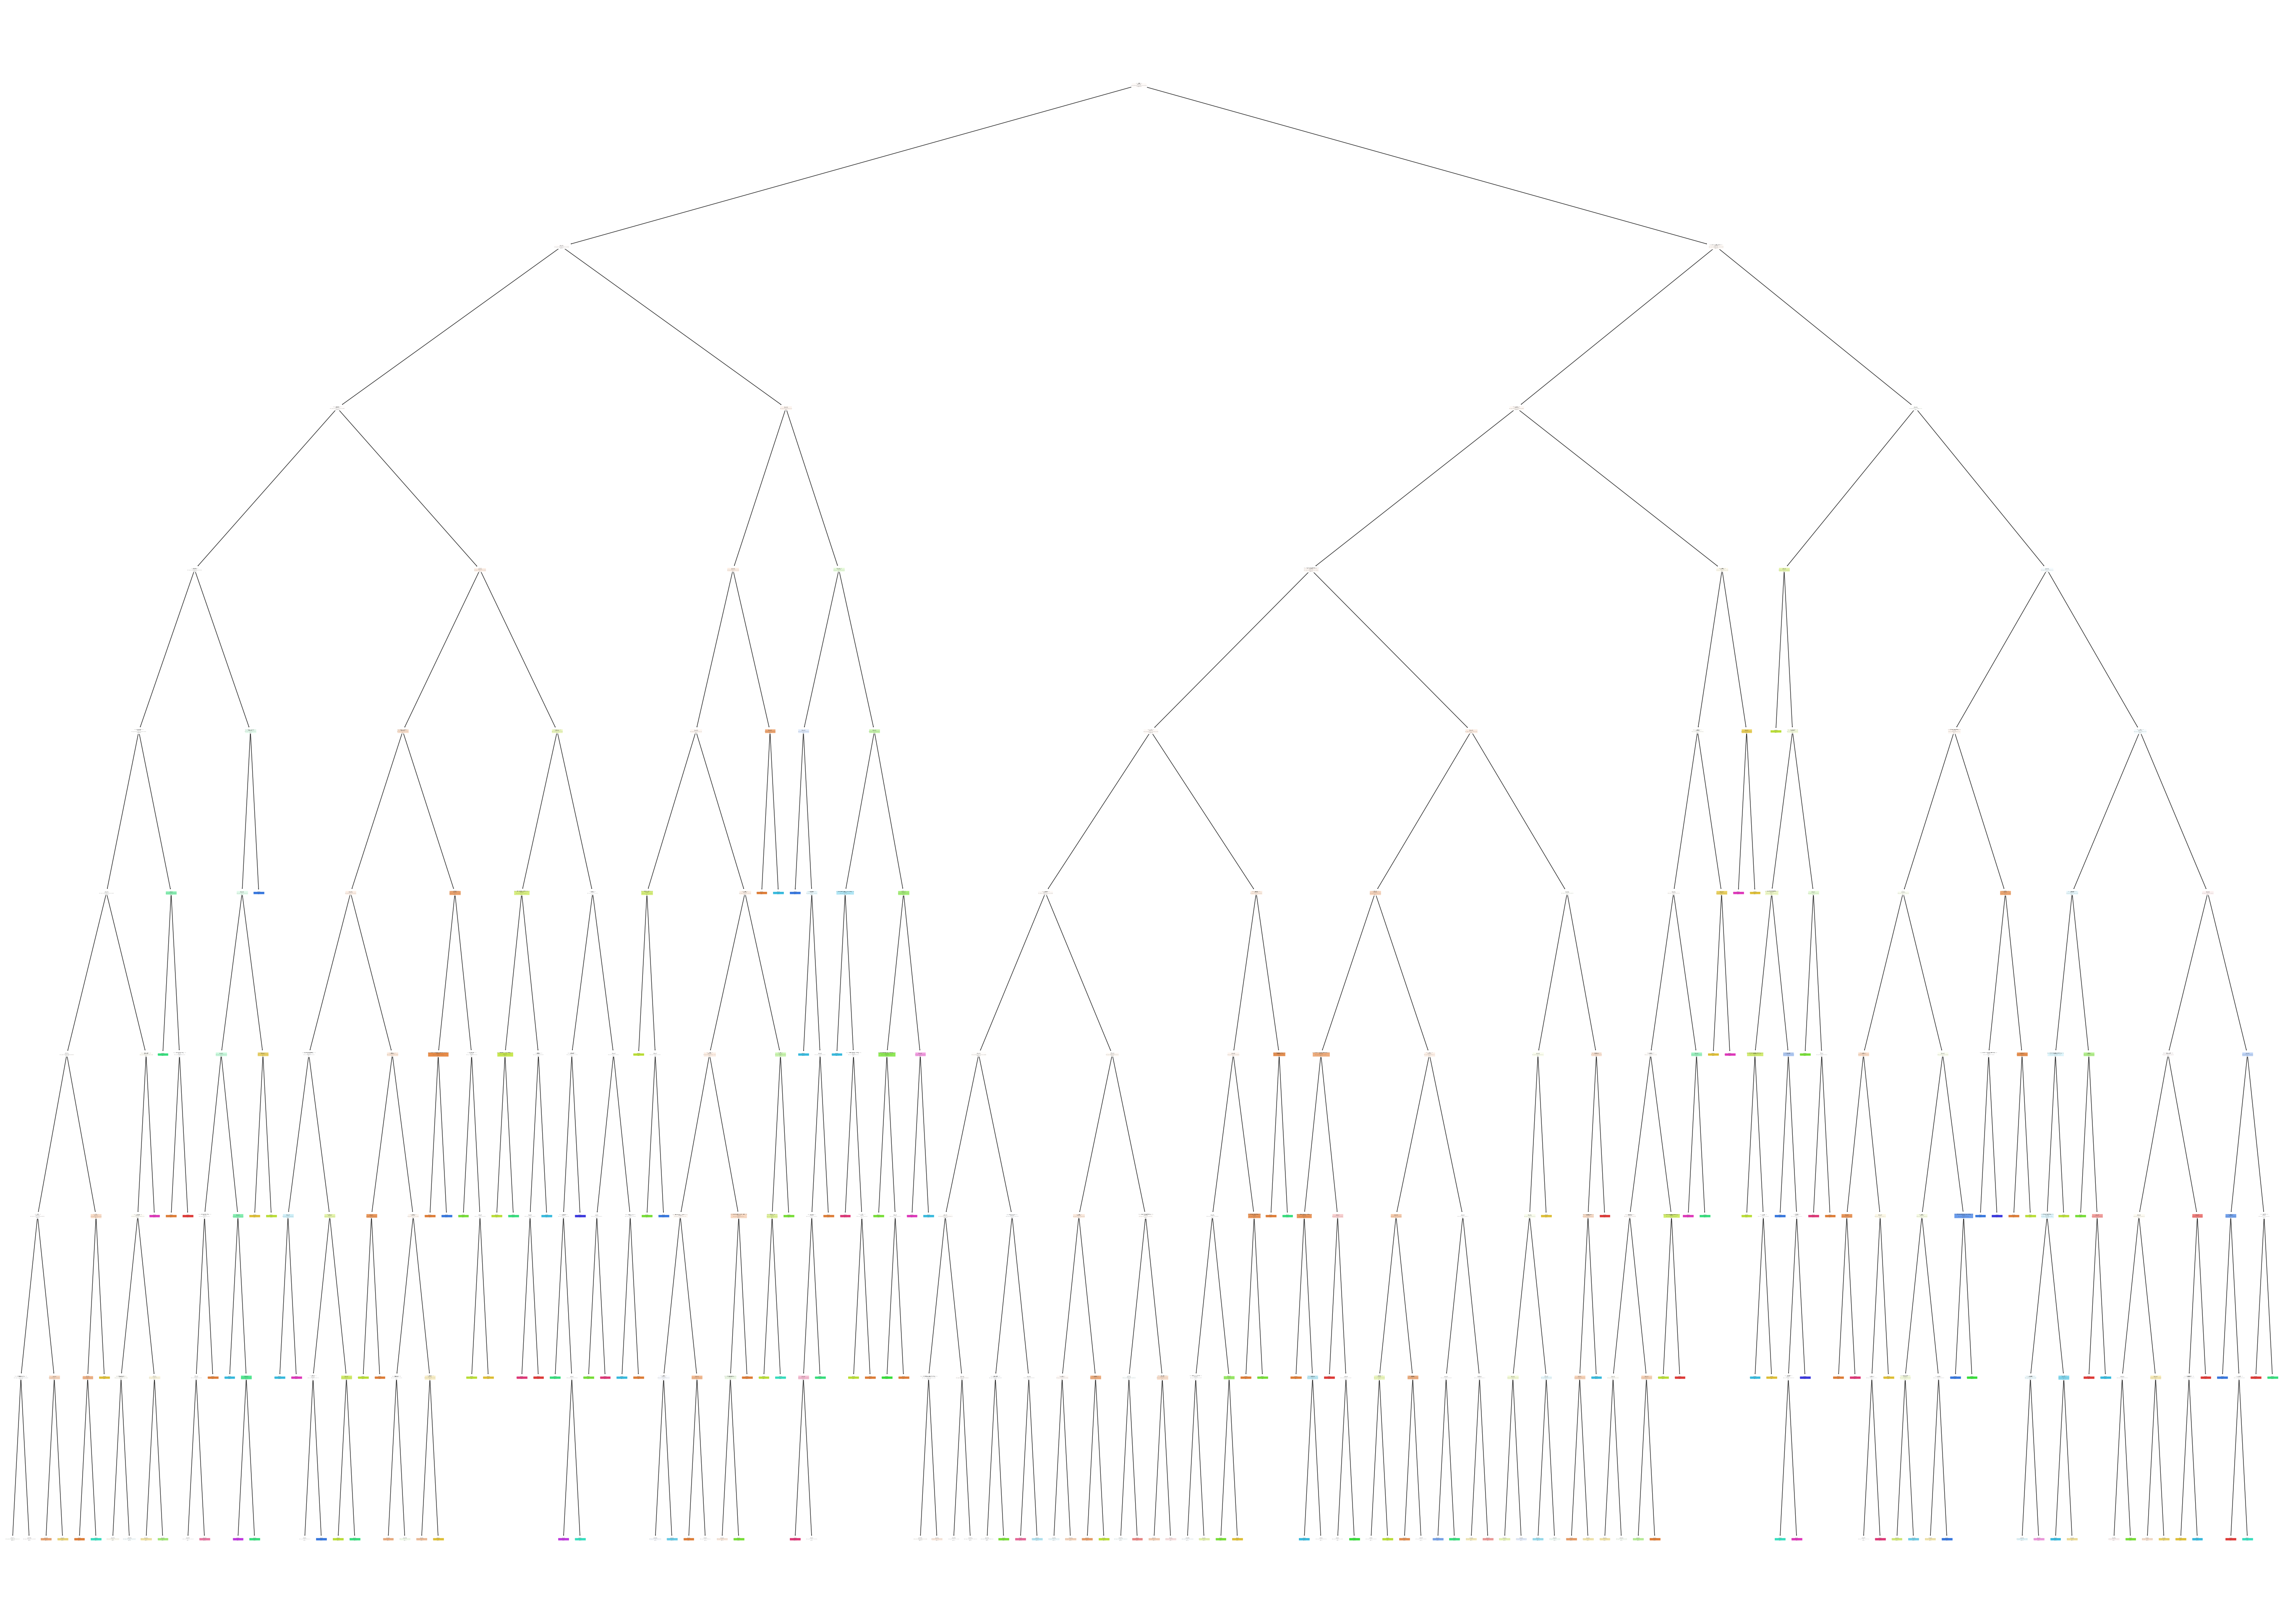

In [44]:
model = DecisionTree(encoded_survey, embedding)
# model.dt = model.make_dt(min_samples_leaf=25, min_impurity_decrease=0.0005)
model.dt = model.make_dt(max_depth=9)
model.visualize_tree(model.dt)

In [53]:
# for idx in model.dt.tree_.feature:
#     print(model.feature_names[idx])

In [55]:
thresholds = list(map(int,model.dt.tree_.threshold))

In [27]:
def dt_feature_importance_raw(self, measure = 'ratio' , normalize = True):
        #중요한 부분. raw input일 때의 feature importtance 추출
    assert measure.lower() in ['ratio','count']
    
    features = self.dt.tree_.feature
    names = self.feature_names
    thresholds = list(map(int,self.dt.tree_.threshold))
    
    node_names = []
    for idx,feature in enumerate(features):
        if feature >= 0:
            name = names[feature]
            if name in ordinal_cols:
                node_names.append(name + '<=' + str(thresholds[idx]))
            else:
                node_names.append(name)
    node_names_left = node_names #왼쪽은 그대로
    # node_names_right = list(map(lambda x : x.replace('<=','>='),node_names))#오른쪽은 반대로
    node_names = node_names_left 

    left_c = self.dt.tree_.children_left
    right_c = self.dt.tree_.children_right
    node_samples = self.dt.tree_.weighted_n_node_samples
    pos_samples = self.dt.tree_.value[:,:,1].squeeze()
    feature_importance = {key : 0 for key in set(node_names)} # pos, neg

# dt.tree_.feature : 각 노드가 순서대로 어떤 feature인지. 
    for idx,feature in enumerate(features): 
        if feature >= 0: #해당 노드가 있으면
            importance_parent = pos_samples[idx] / node_samples[idx]

            if measure == 'ratio':

                for lr,child in enumerate([left_c[idx],right_c[idx]]):
                    importance_child = pos_samples[child] / node_samples[child] # pos sample 비중
                    node_importance = node_samples[idx] * (importance_child - importance_parent) # 비중 변화 측정 
            
                    if node_importance > 0 : # 양수일때만 
                        name = names[feature]
                        if name in ordinal_cols: #ordinal
                            if lr==0: # left --> pos                           해당 노드 특성에 대해서는 +              
                                feature_importance[name+'<='+str(thresholds[idx])] += node_importance    
                            else : #right --> neg 해당 노드 특성에 대해서는 - 
                                feature_importance[name+'<='+str(thresholds[idx])] -= node_importance
                        
                        else: #onehot
                            if lr==0: # left --> pos                           해당 노드 특성에 대해서는 +              
                                feature_importance[name] -= node_importance    
                            else : #right --> neg 해당 노드 특성에 대해서는 - 
                                feature_importance[name] += node_importance
                        

            elif measure == 'count':
                
                for lr,child in enumerate([left_c[idx],right_c[idx]]):
                    #어짜피 방향은 항상 같기 때문에
                    node_importance = pos_samples[idx] * pos_samples[child]                       
                    name  = names[feature]
                    if name in ordinal_cols: #ordinal
                        if lr==0: #left --> +
                                feature_importance[name+'<='+str(thresholds[idx])] += node_importance    
                        else : #right --> -
                                feature_importance[name+'<='+str(thresholds[idx])] -= node_importance
                        
                    else: #onehot
                        if lr==0: # left --> pos                           해당 노드 특성에 대해서는 +              
                            feature_importance[name] -= node_importance    
                        else : #right --> neg 해당 노드 특성에 대해서는 - 
                            feature_importance[name] += node_importance
                        

    feature_importance = {key:value/node_samples[0] for key,value in feature_importance.items()} 
    
    # #정규화해서 양수됐나? 
    # if normalize:
    #     normalizer = sum(feature_importance.values())
    #     feature_importance = {key: value/normalizer for key,value in feature_importance.items()} 

    # else:
    #     feature_importance = {key:value for key,value in feature_importance.items()} 
    
    return feature_importance

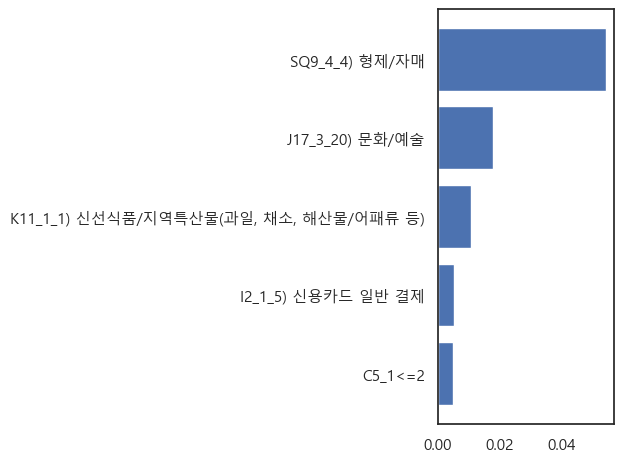

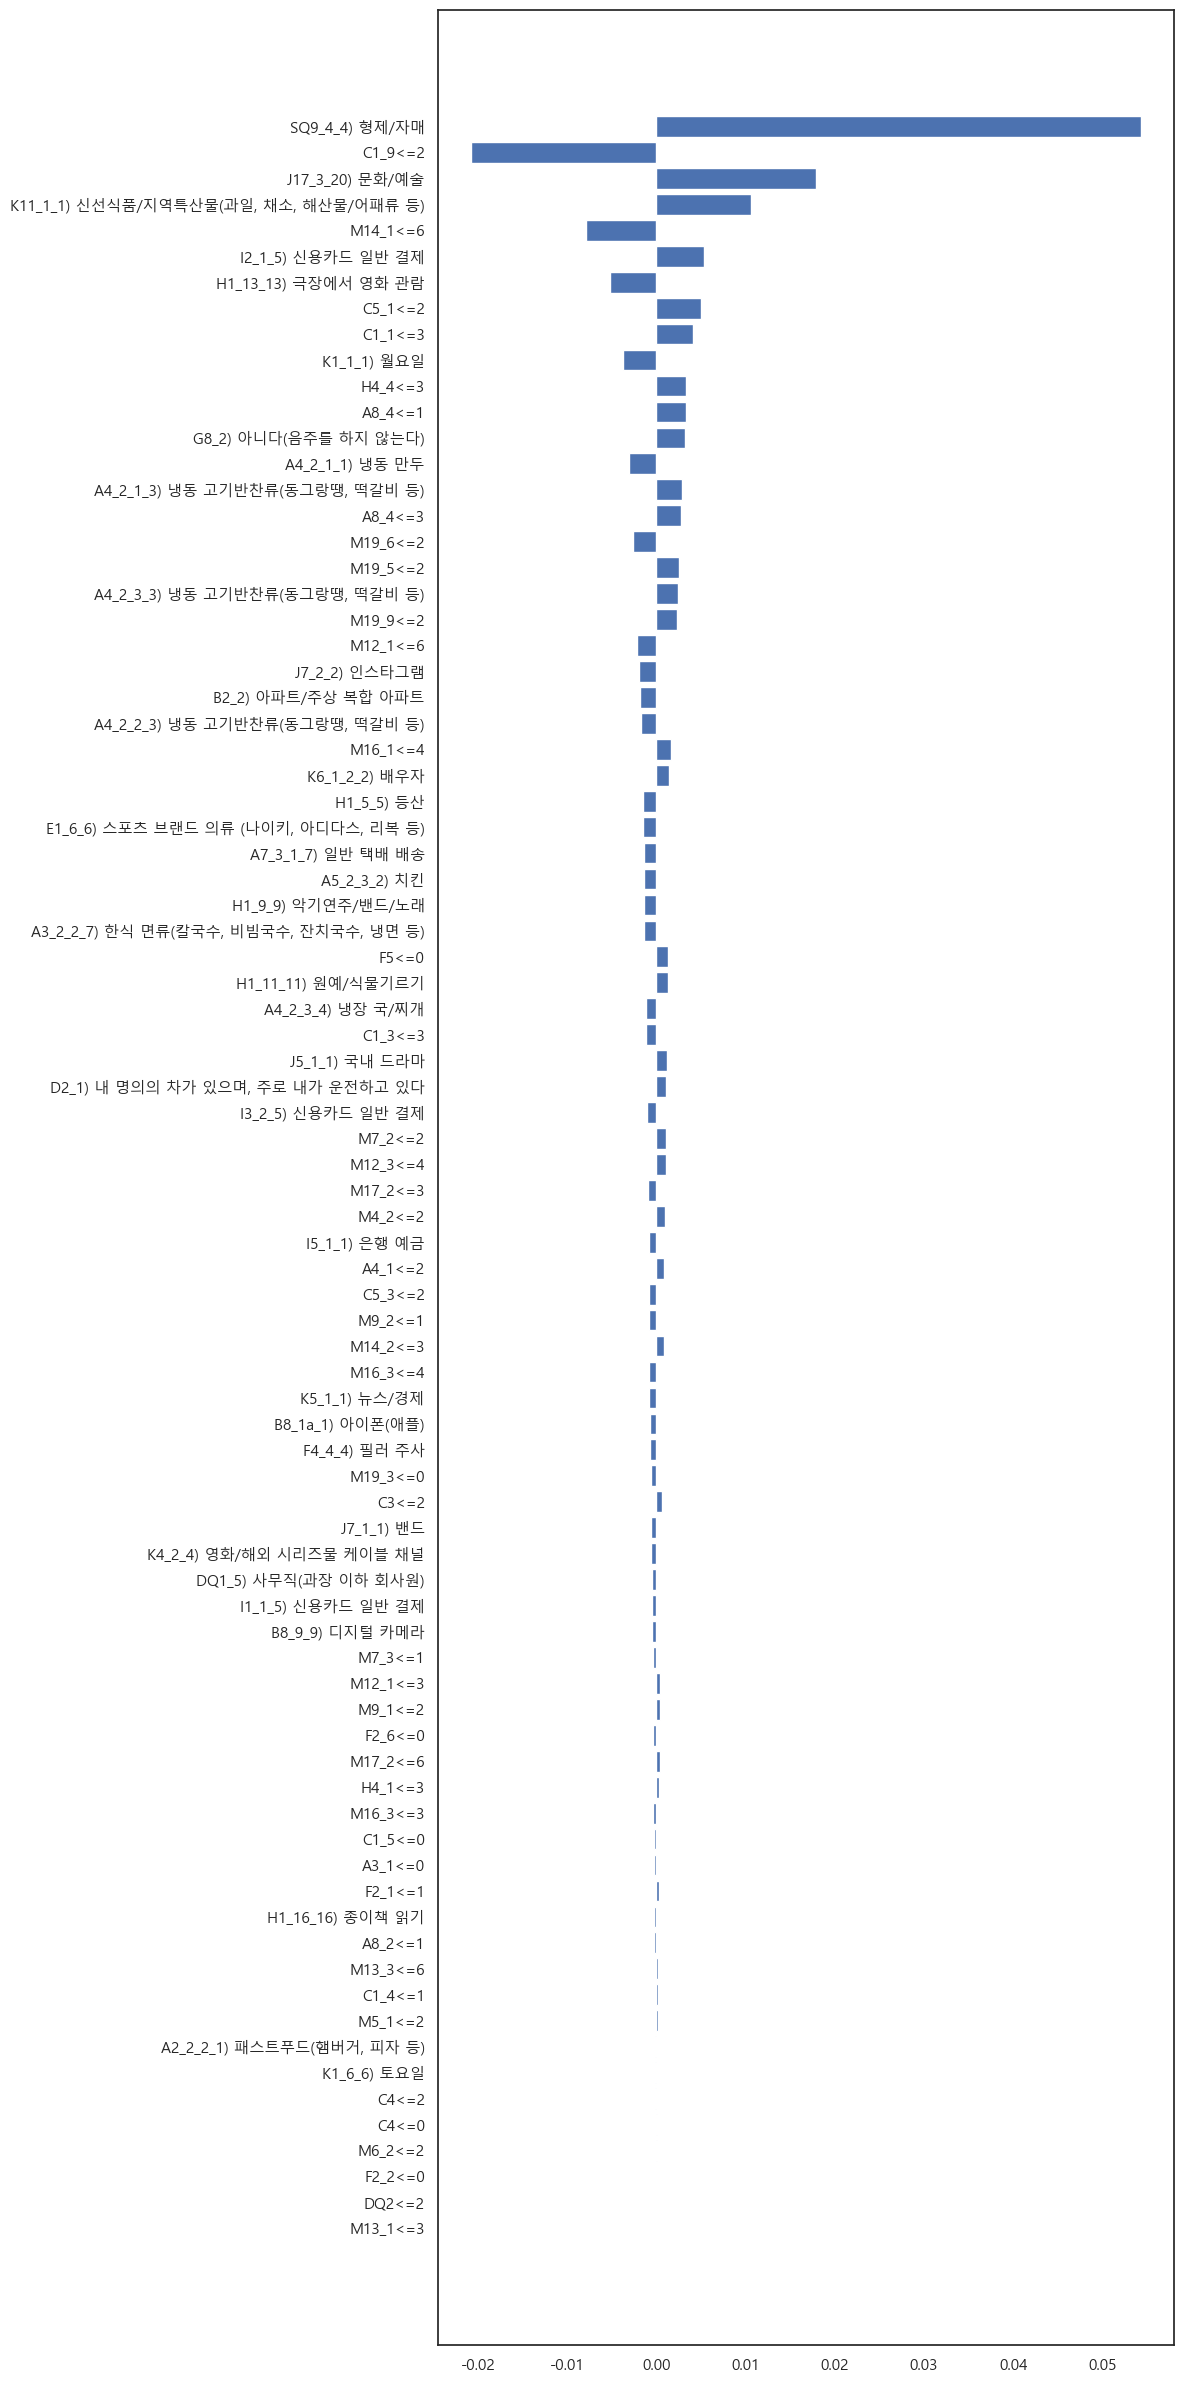

In [32]:
feature_importance =dt_feature_importance_raw(model)
features = np.array(list(feature_importance.keys()))
values = np.array(list(feature_importance.values()))
sorted_idx = np.argsort(abs(values))
top_5 = np.argsort(values)[-5:]

idx  = np.arange(top_5.shape[0])
plt.barh(idx,values[top_5], align='center')
plt.yticks(idx,features[top_5])
plt.tight_layout()

idx  = np.arange(values.shape[0])
plt.figure(figsize=(12,24))
plt.barh(idx,values[sorted_idx], align='center')
plt.yticks(idx,features[sorted_idx])
plt.tight_layout()
plt.show()